<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/main/ueba/UBA_Ptototype_Spell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install tensorflow
# !pip install tensorflow-io
!pip install 'elasticsearch<8'
# !pip install sklearn
!pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 385 kB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#!curl -k https://223.27.235.41:11443/es -u logyou -p

In [4]:
import os
import time
from sklearn.model_selection import train_test_split
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import json
import pandas_profiling as pp
import seaborn as sns
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelextrema
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# import tensorflow_io as tfio

In [5]:
## INIT
# now = datetime.now()
# date_delta = now - timedelta(minutes=5)
# date_now_string = str(now.strftime("%Y-%m-%d %H:%M:%S"))
# date_delta_string = str(date_delta.strftime("%Y-%m-%d %H:%M:%S"))
# ES_IDX = "com*%s" %now.strftime("%Y-%m-%d")
ES_IDX = "com*winevent*"
# ES_IDX = "com*forti*"
#AD active directory
# ES_MISP_ALERT_IDX = "misp_alert_%s" %now.strftime("%Y-%m-%d")

ES_SERVER = "https://223.27.235.41:11443/es"
ES_USER = "logyou"
ES_PASS = "elastic@123"

pd.set_option('display.max_columns', None)

In [6]:
import datetime as DT
today = DT.date.today()
week_ago = today - DT.timedelta(days=1)

ES_BODY = {
                    "_source" : {
                              "excludes" : []
                         },
                          "sort": [
                            {
                              "@timestamp": {
                                "order": "desc"
                              }
                            }
                          ], 
                        "size": 10000,
                        "query": {
                            "bool": {
                            "must": [
                                {
                                "range": {
                                    "@timestamp": {
                                    "gte": str(week_ago)+" 00:00:00",
                                    "lte": str(today)+" 23:59:59",
                                    "format": "yyyy-MM-dd HH:mm:ss"
                                    }
                                }
                                }
                            ],
      "must_not": [
        {"match_phrase": {
          "event_data.TargetImage":  "*Code.exe{0}"
        }}
      ]
                            }
                        },
                        "timeout": "30000ms"
                        }

#print(json.dumps(ES_BODY))

In [7]:

es = Elasticsearch(hosts=["https://223.27.235.41:11443/es"],
                            timeout=30000,
                            http_auth=(ES_USER, ES_PASS),
                            max_retries=10,
                            retry_on_timeout=True,
                            #ssl_context=ssl_context,
                            verify_certs = False)

data = es.search(
    index=ES_IDX,
    body=json.loads(json.dumps(ES_BODY))
)

#print(data)
len(data['hits']['hits'])

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/http_urllib3.py:211: UserWarning: Connecting to https://223.27.235.41:11443 using SSL with verify_certs=False is insecure.
  % self.host
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advis

10000

In [8]:
data.keys()

dict_keys(['took', 'timed_out', '_shards', 'hits'])

In [9]:
data['hits'].keys()

dict_keys(['total', 'max_score', 'hits'])

In [10]:
data['hits']['hits'][0:1]

[{'_id': 'CGHnUoEBd4mrS7sOu0Z3',
  '_index': 'com_1_wineventlog_2022-06-11',
  '_score': None,
  '_source': {'@timestamp': '2022-06-11T20:15:26.952Z',
   '@timestamp_utc': '2022-06-11T13:15:26.952Z',
   '@version': '1',
   'agent': {'ephemeral_id': '7785bdfe-7e24-4e77-9e50-aff2cc19a8c3',
    'hostname': 'WIN-NUTTH-DEV',
    'id': 'ef1508b9-e390-4059-866c-93de171a0230',
    'type': 'winlogbeat',
    'version': '7.2.0'},
   'api': 'wineventlog',
   'channel': 'Microsoft-Windows-Sysmon/Operational',
   'computer_name': 'WIN-NUTTH-DEV',
   'ecs': {'version': '1.0.0'},
   'elasticlogtype': 'wineventlog',
   'event': {'action': 'Process accessed (rule: ProcessAccess)',
    'code': 10,
    'created': '2022-06-11T13:15:27.299Z',
    'description': 'Not Detected',
    'kind': 'event'},
   'event_data': {'CallTrace': 'C:\\Windows\\SYSTEM32\\ntdll.dll+9feb4|C:\\Windows\\System32\\KERNELBASE.dll+2126e|\\\\?\\c:\\Users\\nutth\\AppData\\Local\\Programs\\Microsoft VS Code\\resources\\app\\node_module

In [11]:
#from tabulate import tabulate
df = pd.json_normalize(data['hits'], record_path =['hits'])
# df = df.drop(['_index', '_type','_id','_score','_source.provider_guid','_source.event.created','_source.event_id','_source.provider_name',
#              '_source.provider_name','_source.host','_source.elasticlogtype','_source.event.code','_source.channel','_source.agent.id',
#              '_source.log.level','_source.computer_name','_source.agent.ephemeral_id','_source.agent.hostname','_source.agent.type',
#              '_source.agent.version'], axis=1)
#print(tabulate(df, headers='keys', tablefmt='psql'))
df.head()
#df.info()
#pp.ProfileReport(df) 

,_index,_type,_id,_score,sort,_source.log.level,_source.event.created,_source.event.code,_source.event.action,_source.event.description,_source.event.kind,_source.api,_source.channel,_source.ecs.version,_source.version,_source.@timestamp,_source.provider_name,_source.technique_id,_source.event_id,_source.@timestamp_utc,_source.generated_id,_source.elasticlogtype,_source.message,_source.process.thread.id,_source.process.pid,_source.provider_guid,_source.opcode,_source.host,_source.record_id,_source.event_data.TargetImage,_source.event_data.TargetProcessGUID,_source.event_data.TargetProcessId,_source.event_data.RuleName,_source.event_data.TargetUser,_source.event_data.GrantedAccess,_source.event_data.SourceUser,_source.event_data.CallTrace,_source.@version,_source.computer_name,_source.host_device_type,_source.technique_name,_source.user.domain,_source.user.name,_source.user.identifier,_source.user.type,_source.task,_source.agent.id,_source.agent.hostname,_source.agent.version,_source.agent.ephemeral_id,_source.agent.type,_source.event_data.LayerRTID,_source.event_data.SourceAddress,_source.event_data.Application,_source.event_data.SourcePort,_source.event_data.DestPort,_source.event_data.RemoteUserID,_source.event_data.Protocol,_source.event_data.LayerName,_source.event_data.RemoteMachineID,_source.event_data.ProcessID,_source.event_data.DestAddress,_source.event_data.FilterRTID,_source.event_data.Direction,_source.keywords,_source.event_data.ProcessId,_source.event_data.SubjectDomainName,_source.event_data.AccessList,_source.event_data.ObjectType,_source.event_data.AccessMask,_source.event_data.SubjectLogonId,_source.event_data.ObjectName,_source.event_data.RestrictedSidCount,_source.event_data.ObjectServer,_source.event_data.SubjectUserSid,_source.event_data.PrivilegeList,_source.event_data.ResourceAttributes,_source.event_data.ProcessName,_source.event_data.SubjectUserName,_source.event_data.AccessReason,_source.event_data.HandleId,_source.event_data.TransactionId,_source.event_data.UtcTime,_source.event_data.QueryResults,_source.event_data.QueryName,_source.event_data.User,_source.event_data.Image,_source.event_data.QueryStatus,_source.event_data.ProcessGuid,_source.error.message,_source.event_data.CountOfCredentialsReturned,_source.event_data.ReturnCode,_source.event_data.ClientProcessId,_source.event_data.TargetName,_source.event_data.ProcessCreationTime,_source.event_data.ReadOperation,_source.event_data.Type,_source.activity_id,_source.source.domain,_source.event.category,_source.event.type,_source.alert_match,_source.event_data.LogonGuid,_source.event_data.VirtualAccount,_source.event_data.TargetOutboundDomainName,_source.event_data.IpPort,_source.event_data.TargetOutboundUserName,_source.event_data.KeyLength,_source.event_data.TargetLinkedLogonId,_source.event_data.LogonType,_source.event_data.LmPackageName,_source.event_data.TransmittedServices,_source.event_data.RestrictedAdminMode,_source.event_data.IpAddress,_source.event_data.ImpersonationLevel,_source.event_data.ElevatedToken,_source.event_data.TargetLogonId,_source.event_data.LogonProcessName,_source.event_data.AuthenticationPackageName,_source.user.id,_source.file.path,_source.event_data.CreationUtcTime
0,com_1_wineventlog_2022-06-11,_doc,CGHnUoEBd4mrS7sOu0Z3,None,[1654978526952],information,2022-06-11T13:15:27.299Z,10,Process accessed (rule: ProcessAccess),Not Detected,event,wineventlog,Microsoft-Windows-Sysmon/Operational,1.0.0,3.0,2022-06-11T20:15:26.952Z,Microsoft-Windows-Sysmon,T1036,10,2022-06-11T13:15:26.952Z,8f81cbcf-fa84-47a3-bd26-567a2fd826b6,wineventlog,2022-06-11T20:15:26.952Z Process accessed:Rule...,8868,4064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Info,192.168.0.25,12295221,C:\Users\nutth\AppData\Local\Programs\Microsof...,{6c71184a-609c-6298-9d02-000000001c00},1504,"technique_id=T1036,technique_name=Masquerading",WIN-NUTTH-DEV\nutth,0x100000,WIN-NUTTH-DEV\nutth,C:\Windows\SYSTEM32\ntdll.dll+9feb4|C:\Windows...,1,WIN-NUTTH-DEV,wineventlog_microso

In [52]:
#           '<Date> <Time> <Pid> <Level> <Component>: <Content>'
_df = df[['_source.event.created','_source.process.pid','_source.log.level', '_source.computer_name', '_source.message']]
_df
_df4 = _df[['_source.process.pid','_source.log.level','_source.computer_name']]
_df4

,_source.process.pid,_source.log.level,_source.computer_name
0,4064,information,WIN-NUTTH-DEV
1,4064,information,WIN-NUTTH-DEV
2,4,information,WIN-NUTTH-DEV
3,4,information,WIN-NUTTH-DEV
4,4,information,WIN-NUTTH-DEV
...,...,...,...
9995,4,information,WIN-NUTTH-DEV
9996,4,information,WIN-NUTTH-DEV
9997,4,information,WIN-NUTTH-DEV
9998,4,information,WIN-NUTTH-DEV


In [13]:
# split column and add new columns to df
_df2 = _df['_source.event.created'].str.split('T', expand=True)
_df2.columns = ['Date','Time']
print(_df2)


            Date           Time
0     2022-06-11  13:15:27.299Z
1     2022-06-11  13:15:27.299Z
2     2022-06-11  13:15:27.485Z
3     2022-06-11  13:15:27.485Z
4     2022-06-11  13:15:27.485Z
...          ...            ...
9995  2022-06-11  13:10:05.130Z
9996  2022-06-11  13:10:05.130Z
9997  2022-06-11  13:10:05.130Z
9998  2022-06-11  13:10:05.130Z
9999  2022-06-11  13:10:05.129Z

[10000 rows x 2 columns]


In [14]:
# split column and add new columns to df
_df3 = _df['_source.message'].str.split('Z ', expand=True)
_df3 = _df3.iloc[: , 1:]
_df3.columns = ['Message']
print(_df3)

                                                Message
0     Process accessed:RuleName: technique_id=T1036,...
1     Process accessed:RuleName: technique_id=T1036,...
2     The Windows Filtering Platform has permitted a...
3     The Windows Filtering Platform has permitted a...
4     The Windows Filtering Platform has permitted a...
...                                                 ...
9995  The Windows Filtering Platform has permitted a...
9996  The Windows Filtering Platform has permitted a...
9997  The Windows Filtering Platform has permitted a...
9998  The Windows Filtering Platform has permitted a...
9999  The Windows Filtering Platform has permitted a...

[10000 rows x 1 columns]


#Prepare code for spell parser

In [54]:
result = pd.concat([_df2,_df4, _df3], axis=1)
print(result.head())
result.to_csv("train_data.csv")

         Date           Time  _source.process.pid _source.log.level  \
0  2022-06-11  13:15:27.299Z                 4064       information   
1  2022-06-11  13:15:27.299Z                 4064       information   
2  2022-06-11  13:15:27.485Z                    4       information   
3  2022-06-11  13:15:27.485Z                    4       information   
4  2022-06-11  13:15:27.485Z                    4       information   

  _source.computer_name                                            Message  
0         WIN-NUTTH-DEV  Process accessed:RuleName: technique_id=T1036,...  
1         WIN-NUTTH-DEV  Process accessed:RuleName: technique_id=T1036,...  
2         WIN-NUTTH-DEV  The Windows Filtering Platform has permitted a...  
3         WIN-NUTTH-DEV  The Windows Filtering Platform has permitted a...  
4         WIN-NUTTH-DEV  The Windows Filtering Platform has permitted a...  


In [16]:
my_list = df.columns.values.tolist()
my_list

['_index',
 '_type',
 '_id',
 '_score',
 'sort',
 '_source.log.level',
 '_source.event.created',
 '_source.event.code',
 '_source.event.action',
 '_source.event.description',
 '_source.event.kind',
 '_source.api',
 '_source.channel',
 '_source.ecs.version',
 '_source.version',
 '_source.@timestamp',
 '_source.provider_name',
 '_source.technique_id',
 '_source.event_id',
 '_source.@timestamp_utc',
 '_source.generated_id',
 '_source.elasticlogtype',
 '_source.message',
 '_source.process.thread.id',
 '_source.process.pid',
 '_source.provider_guid',
 '_source.opcode',
 '_source.host',
 '_source.record_id',
 '_source.event_data.TargetImage',
 '_source.event_data.TargetProcessGUID',
 '_source.event_data.TargetProcessId',
 '_source.event_data.RuleName',
 '_source.event_data.TargetUser',
 '_source.event_data.GrantedAccess',
 '_source.event_data.SourceUser',
 '_source.event_data.CallTrace',
 '_source.@version',
 '_source.computer_name',
 '_source.host_device_type',
 '_source.technique_name',
 '

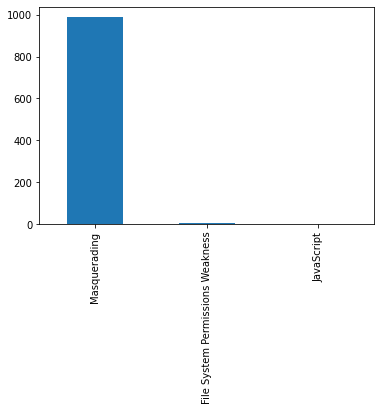

In [17]:
df['_source.technique_name'].value_counts().plot(kind='bar')

In [18]:
print(df.shape)

df = df.drop(['_index', '_type','_id','_score'], axis=1)
# df = df.dropna(axis='columns')
df = df[sorted(df.columns)]
# df = df.sort_values(by='_source.@timestamp')
# df["_source.event_id"] = df["_source.event_id"].astype("int64")
# df["_source.event.code"] = df["_source.event.code"].astype("int64", errors='ignore')
# df["_source.log.level"] = df["_source.log.level"].astype("int64", errors='ignore')

# df = df.convert_dtypes()
# df.describe(include='all')
#df.head()
df.info()
df.isnull().sum()
df.head()

(10000, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 118 entries, _source.@timestamp to sort
dtypes: float64(1), int64(5), object(112)
memory usage: 9.0+ MB


,_source.@timestamp,_source.@timestamp_utc,_source.@version,_source.activity_id,_source.agent.ephemeral_id,_source.agent.hostname,_source.agent.id,_source.agent.type,_source.agent.version,_source.alert_match,_source.api,_source.channel,_source.computer_name,_source.ecs.version,_source.elasticlogtype,_source.error.message,_source.event.action,_source.event.category,_source.event.code,_source.event.created,_source.event.description,_source.event.kind,_source.event.type,_source.event_data.AccessList,_source.event_data.AccessMask,_source.event_data.AccessReason,_source.event_data.Application,_source.event_data.AuthenticationPackageName,_source.event_data.CallTrace,_source.event_data.ClientProcessId,_source.event_data.CountOfCredentialsReturned,_source.event_data.CreationUtcTime,_source.event_data.DestAddress,_source.event_data.DestPort,_source.event_data.Direction,_source.event_data.ElevatedToken,_source.event_data.FilterRTID,_source.event_data.GrantedAccess,_source.event_data.HandleId,_source.event_data.Image,_source.event_data.ImpersonationLevel,_source.event_data.IpAddress,_source.event_data.IpPort,_source.event_data.KeyLength,_source.event_data.LayerName,_source.event_data.LayerRTID,_source.event_data.LmPackageName,_source.event_data.LogonGuid,_source.event_data.LogonProcessName,_source.event_data.LogonType,_source.event_data.ObjectName,_source.event_data.ObjectServer,_source.event_data.ObjectType,_source.event_data.PrivilegeList,_source.event_data.ProcessCreationTime,_source.event_data.ProcessGuid,_source.event_data.ProcessID,_source.event_data.ProcessId,_source.event_data.ProcessName,_source.event_data.Protocol,_source.event_data.QueryName,_source.event_data.QueryResults,_source.event_data.QueryStatus,_source.event_data.ReadOperation,_source.event_data.RemoteMachineID,_source.event_data.RemoteUserID,_source.event_data.ResourceAttributes,_source.event_data.RestrictedAdminMode,_source.event_data.RestrictedSidCount,_source.event_data.ReturnCode,_source.event_data.RuleName,_source.event_data.SourceAddress,_source.event_data.SourcePort,_source.event_data.SourceUser,_source.event_data.SubjectDomainName,_source.event_data.SubjectLogonId,_source.event_data.SubjectUserName,_source.event_data.SubjectUserSid,_source.event_data.TargetImage,_source.event_data.TargetLinkedLogonId,_source.event_data.TargetLogonId,_source.event_data.TargetName,_source.event_data.TargetOutboundDomainName,_source.event_data.TargetOutboundUserName,_source.event_data.TargetProcessGUID,_source.event_data.TargetProcessId,_source.event_data.TargetUser,_source.event_data.TransactionId,_source.event_data.TransmittedServices,_source.event_data.Type,_source.event_data.User,_source.event_data.UtcTime,_source.event_data.VirtualAccount,_source.event_id,_source.file.path,_source.generated_id,_source.host,_source.host_device_type,_source.keywords,_source.log.level,_source.message,_source.opcode,_source.process.pid,_source.process.thread.id,_source.provider_guid,_source.provider_name,_source.record_id,_source.source.domain,_source.task,_source.technique_id,_source.technique_name,_source.user.domain,_source.user.id,_source.user.identifier,_source.user.name,_source.user.type,_source.version,sort
0,2022-06-11T20:15:26.952Z,2022-06-11T13:15:26.952Z,1,NaN,7785bdfe-7e24-4e77-9e50-aff2cc19a8c3,WIN-NUTTH-DEV,ef1508b9-e390-4059-866c-93de171a0230,winlogbeat,7.2.0,NaN,wineventlog,Microsoft-Windows-Sysmon/Operational,WIN-NUTTH-DEV,1.0.0,wineventlog,NaN,Process accessed (rule: ProcessAccess),NaN,10,2022-06-11T13:15:27.299Z,Not Detected,event,NaN,NaN,NaN,NaN,NaN,NaN,C:\Windows\SYSTEM32\ntdll.dll+9feb4|C:\Windows...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"technique_id=T1036,technique_name=Masquerading",NaN,NaN,WIN-NUTTH-DEV\nutth,NaN,NaN,NaN,NaN,C:\Users\nutth\AppData\Local\Programs\Microsof...,NaN,NaN,NaN,NaN,NaN,{6c71184a-609c-6298-9d02-000000001c00},1504,WIN

In [19]:
df3 = df[df['_source.technique_id']=='T1036']
df3.head()
df3['_source.event_data.TargetImage'].unique()

array(['C:\\Users\\nutth\\AppData\\Local\\Programs\\Microsoft VS Code\\Code.exe'],
      dtype=object)

In [20]:
df3 = df[['_source.@timestamp','_source.technique_id','_source.technique_name']] #,'_source.computer_name','_source.event.action','_source.event_data.CallTrace']]
df3 = df3.sort_values(by='_source.@timestamp')
df3 = df3.dropna()
#df3 = df3[df3['_source.technique_id'] != "Port Monitors"]
#df3 = df3[df3['_source.technique_id'] != "T"]

#print(df3["_source.technique_id"])

#df3["_source.technique_id"] = df3['_source.technique_id'].str[1:].astype(np.double).replace(210,1210) #
# df5["_source.@timestamp"] = pd.to_datetime(df5['_source.@timestamp'].astype(str)).values.astype(np.int64) // 10 ** 6
#df3["_source.@timestamp"] = df3['_source.@timestamp'].astype(str).str[11:15].str.replace(':', '', regex=True)
#df3 = pd.get_dummies(df3['_source.technique_id']).groupby(df['_source.@timestamp']).apply(max)
#df3.drop_duplicates(inplace = True)
#df3.head()
#df3.describe(include='all')
df3.head()

,_source.@timestamp,_source.technique_id,_source.technique_name
9979,2022-06-11T20:10:04.635Z,T1036,Masquerading
9978,2022-06-11T20:10:04.756Z,T1036,Masquerading
9975,2022-06-11T20:10:05.250Z,T1036,Masquerading
9974,2022-06-11T20:10:05.635Z,T1036,Masquerading
9973,2022-06-11T20:10:05.756Z,T1036,Masquerading


In [21]:
df3['_source.technique_id'].unique()

array(['T1036', 'T1047', 'T1059.007'], dtype=object)

In [22]:
df3['_source.technique_name'].unique()

array(['Masquerading', 'File System Permissions Weakness', 'JavaScript'],
      dtype=object)

In [23]:
df3.head()

,_source.@timestamp,_source.technique_id,_source.technique_name
9979,2022-06-11T20:10:04.635Z,T1036,Masquerading
9978,2022-06-11T20:10:04.756Z,T1036,Masquerading
9975,2022-06-11T20:10:05.250Z,T1036,Masquerading
9974,2022-06-11T20:10:05.635Z,T1036,Masquerading
9973,2022-06-11T20:10:05.756Z,T1036,Masquerading


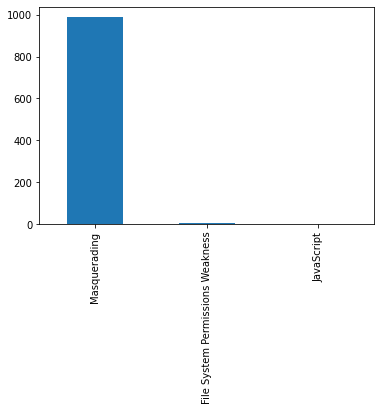

In [24]:
df3['_source.technique_name'].value_counts().plot(kind='bar')

In [25]:
df3.head()
df3[0:20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 9979 to 9858
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _source.@timestamp      20 non-null     object
 1   _source.technique_id    20 non-null     object
 2   _source.technique_name  20 non-null     object
dtypes: object(3)
memory usage: 640.0+ bytes


In [26]:
from datetime import date
dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)
 
labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 'The Beatles appear\non the Ed Sullivan Show', 
          'Bob Dylan goes electric', 'The Beatles release\nSgt. Pepper', 'Woodstock']
# labels with associated dates
print(dates)
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]
print(labels)

[datetime.date(1954, 7, 19), datetime.date(1959, 2, 3), datetime.date(1964, 2, 9), datetime.date(1965, 7, 25), datetime.date(1967, 6, 1), datetime.date(1969, 8, 15)]
['19 Jul 1954:\nElvis appears on\nthe Ed Sullivan Show', '03 Feb 1959:\nBuddy Holly dies', '09 Feb 1964:\nThe Beatles appear\non the Ed Sullivan Show', '25 Jul 1965:\nBob Dylan goes electric', '01 Jun 1967:\nThe Beatles release\nSgt. Pepper', '15 Aug 1969:\nWoodstock']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


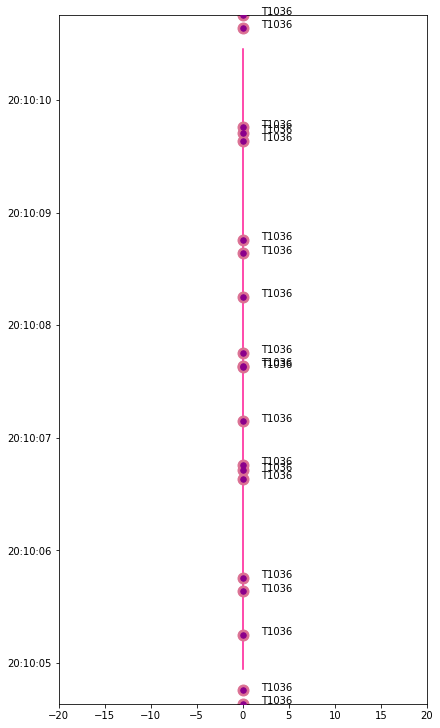

In [27]:
from datetime import timedelta
from datetime import datetime
df4 = df3[0:20]
#print((dates["_source.@timestamp"].values))
df4["_source.@timestamp"] = df4["_source.@timestamp"].apply(pd.to_datetime)
#print(df4)
min_date = df4["_source.@timestamp"].iloc[0]
max_date = df4["_source.@timestamp"].iloc[-1]
fig, ax = plt.subplots(figsize=(6, 10), constrained_layout=True)
_ = ax.set_xlim(-20, 20)
_ = ax.set_ylim(min_date, max_date)
_ = ax.axvline(0, ymin=0.05, ymax=0.95, c='deeppink', zorder=1)
_ = ax.scatter(np.zeros(len(df4)), df4["_source.@timestamp"], s=120, c='palevioletred', zorder=2)
_ = ax.scatter(np.zeros(len(df4)), df4["_source.@timestamp"], s=30, c='darkmagenta', zorder=3)

label_offsets = np.full(len(df4),2)
for i, txt in enumerate(df4["_source.technique_id"].values):
  #print(txt)
  #print(np.zeros(len(df4))[i])
  #print(df4["_source.@timestamp"].iloc[i])
  ax.text(label_offsets[i], df4["_source.@timestamp"].iloc[i],txt)


In [28]:
df5 = df[['_source.@timestamp','_source.technique_id']]
df5 = df5.sort_values(by='_source.@timestamp')
df5 = df5.dropna()
df5 = df5[df5['_source.technique_id'] != "Port Monitors"]
df5 = df5[df5['_source.technique_id'] != "T"]

df5["_source.technique_id"] = df5['_source.technique_id'].str[1:].astype(np.double).replace(210,1210)
# df5["_source.@timestamp"] = pd.to_datetime(df5['_source.@timestamp'].astype(str)).values.astype(np.int64) // 10 ** 6
df5["_source.@timestamp"] = df5['_source.@timestamp'].astype(str).str[11:15].str.replace(':', '', regex=True)
df5.drop_duplicates(inplace = True)
df5

,_source.@timestamp,_source.technique_id
9979,201,1036.000
8846,201,1047.000
1048,201,1059.007


In [29]:
corr = df5.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,_source.technique_id
_source.technique_id,1.000000


In [30]:
df5['_source.technique_id'].value_counts()

1036.000    1
1047.000    1
1059.007    1
Name: _source.technique_id, dtype: int64

In [31]:
df5.shape[0]

3

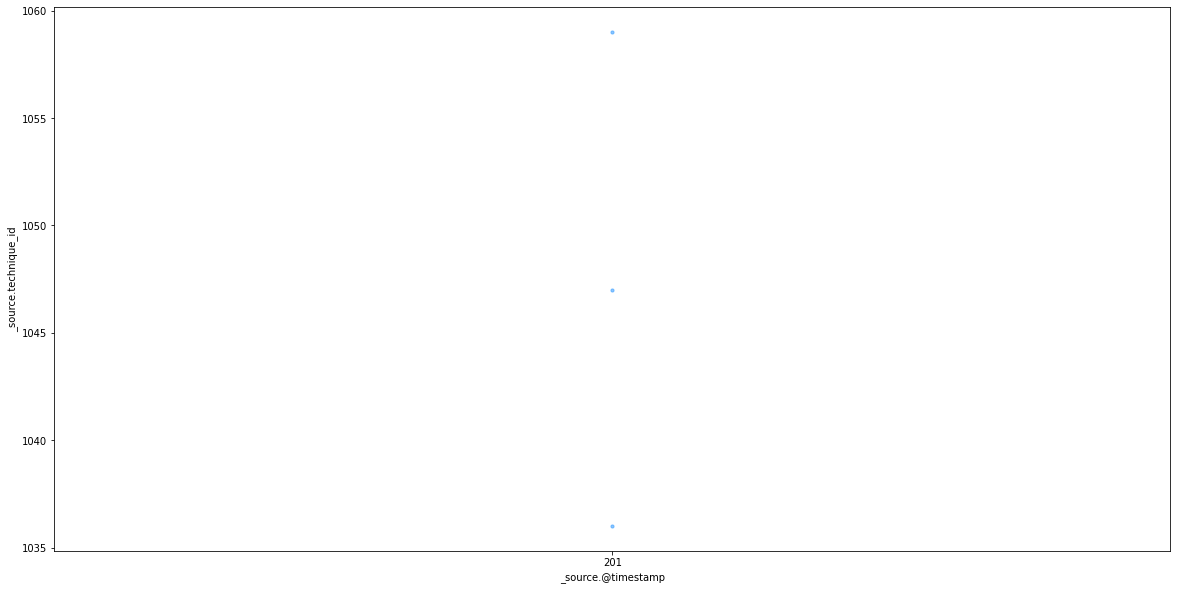

In [32]:
# df5['_source.technique_id'].plot(kind='hist', figsize=(8,5))
df5.plot(kind='scatter', x='_source.@timestamp', y='_source.technique_id', \
        color='dodgerblue', figsize=(20,10), s=10, alpha=0.5)

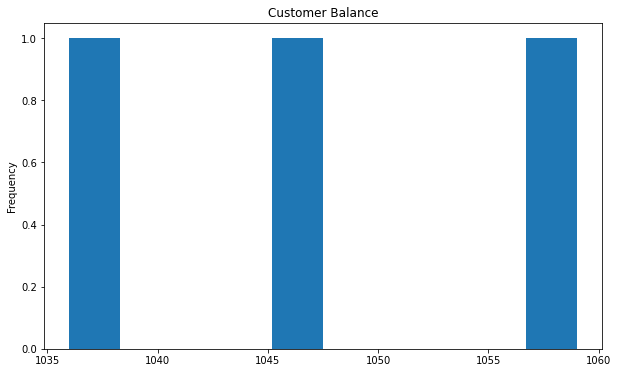

In [33]:
df5['_source.technique_id'].plot(kind='hist', figsize=(10,6), 
title='Customer Balance')

In [34]:
# from sklearn import svm
# from sklearn.covariance import EllipticEnvelope
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

# df_tmp = [np.array(df5.values.tolist())]

# # print(df_tmp)

# n_samples = len(df_tmp)
# outliers_fraction = 0.15
# n_outliers = int(outliers_fraction * n_samples)
# n_inliers = n_samples - n_outliers

# anomaly_algorithms = [
#     ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
#     ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
#                                       gamma=0.1)),
#     ("Isolation Forest", IsolationForest(
#                                          contamination=outliers_fraction,
#                                          random_state=42)),
#     ("Local Outlier Factor", LocalOutlierFactor(
#         n_neighbors=35, contamination=outliers_fraction))]

# # Define datasets
# blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
# datasets = df_tmp

# # Compare given classifiers under given settings
# xx, yy = np.meshgrid(np.linspace(-15, 15, 150),
#                      np.linspace(-15, 15, 150))

# plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                     hspace=.01)

# plot_num = 1
# rng = np.random.RandomState(42)

# for i_dataset, X in enumerate(datasets):

#     for name, algorithm in anomaly_algorithms:
#         t0 = time.time()
#         algorithm.fit(X)
#         t1 = time.time()
#         plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
#         if i_dataset == 0:
#             plt.title(name, size=18)

#         # fit the data and tag outliers
#         if name == "Local Outlier Factor":
#             y_pred = algorithm.fit_predict(X)
#         else:
#             y_pred = algorithm.fit(X).predict(X)

#         # plot the levels lines and the points
#         if name != "Local Outlier Factor":  # LOF does not implement predict
#             Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
#             Z = Z.reshape(xx.shape)
#             plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

#         colors = np.array(['#377eb8', '#ff7f00'])
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

#         plt.xlim(-30, 30)
#         plt.ylim(-5, 30)
#         plt.xticks(())
#         plt.yticks(())
#         plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
#                  transform=plt.gca().transAxes, size=15,
#                  horizontalalignment='right')
#         plot_num += 1

# plt.show()

In [35]:
ES_BODY = {
                    "_source" : {
                              "exclude" : ["message","host_device_type","*IPGeo"]
                         },
                          "sort": [
                            {
                              "@timestamp": {
                                "order": "desc"
                              }
                            }
                          ], 
                        "size": 10000,
                        "query": {
                            "bool": {
                            "must": [
                                {
                                "range": {
                                    "@timestamp": {
                                    "gte": str(week_ago)+" 00:00:00",
                                    "lte": str(today)+" 23:59:59",
                                    "format": "yyyy-MM-dd HH:mm:ss"
                                    }
                                }
                                }
                            ],
      "must_not": [
        {"match_phrase": {
          "event_data.TargetImage":  "*Code.exe"
        }}
      ]
                            }
                        },
                        "timeout": "30000ms"
                        }

es = Elasticsearch(hosts=["https://223.27.235.41:11443/es"],
                            timeout=30000,
                            http_auth=(ES_USER, ES_PASS),
                            max_retries=10,
                            retry_on_timeout=True,
                            #ssl_context=ssl_context,
                            verify_certs = False)


data = es.search(
    index=ES_IDX,
    body=json.loads(json.dumps(ES_BODY))
)

df_today = pd.json_normalize(data['hits'], record_path =['hits'])
# df = df.drop(['_index', '_type','_id','_score','_source.provider_guid','_source.event.created','_source.event_id','_source.provider_name',
#              '_source.provider_name','_source.host','_source.elasticlogtype','_source.event.code','_source.channel','_source.agent.id',
#              '_source.log.level','_source.computer_name','_source.agent.ephemeral_id','_source.agent.hostname','_source.agent.type',
#              '_source.agent.version'], axis=1)

print(df_today.head())

#df_today = df_today.drop(['_index', '_type','_id','_score'], axis=1)

# df = df.dropna(axis='columns')
#df_today = df_today[sorted(df_today.columns)]
# df = df.sort_values(by='_source.@timestamp')
# df["_source.event_id"] = df["_source.event_id"].astype("int64")
# df["_source.event.code"] = df["_source.event.code"].astype("int64", errors='ignore')
# df["_source.log.level"] = df["_source.log.level"].astype("int64", errors='ignore')

# df = df.convert_dtypes()
# df.describe(include='all')
#df_today

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/http_urllib3.py:211: UserWarning: Connecting to https://223.27.235.41:11443 using SSL with verify_certs=False is insecure.
  % self.host
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3

                         _index _type                   _id _score  \
0  com_1_wineventlog_2022-06-11  _doc  aWHnUoEBd4mrS7sO6Uf6   None   
1  com_1_wineventlog_2022-06-11  _doc  fGHnUoEBd4mrS7sO6Uf8   None   
2  com_1_wineventlog_2022-06-11  _doc  bmHnUoEBd4mrS7sO6Uf6   None   
3  com_1_wineventlog_2022-06-11  _doc  cWHnUoEBd4mrS7sO6Uf6   None   
4  com_1_wineventlog_2022-06-11  _doc  j2HnUoEBd4mrS7sO6Uf8   None   

              sort _source.computer_name _source.agent.hostname  \
0  [1654978538440]         WIN-NUTTH-DEV          WIN-NUTTH-DEV   
1  [1654978538440]         WIN-NUTTH-DEV          WIN-NUTTH-DEV   
2  [1654978538439]         WIN-NUTTH-DEV          WIN-NUTTH-DEV   
3  [1654978538439]         WIN-NUTTH-DEV          WIN-NUTTH-DEV   
4  [1654978538025]         WIN-NUTTH-DEV          WIN-NUTTH-DEV   

                       _source.agent.id            _source.agent.ephemeral_id  \
0  ef1508b9-e390-4059-866c-93de171a0230  7785bdfe-7e24-4e77-9e50-aff2cc19a8c3   
1  ef1508b9-e3

In [36]:
df_today_c = df_today[['_source.@timestamp','_source.technique_id']]
df_today_c = df_today_c.sort_values(by='_source.@timestamp')
df_today_c = df_today_c.dropna()
df_today_c["_source.technique_id"] = df_today_c['_source.technique_id'].str[1:].astype(np.double).replace(210,1210)
# df_today_c["_source.@timestamp"] = pd.to_datetime(df_today_c['_source.@timestamp'].astype(str)).values.astype(np.int64) // 10 ** 6
df_today_c["_source.@timestamp"] = df_today_c['_source.@timestamp'].astype(str).str[11:15].str.replace(':', '', regex=True)
df_today_c

,_source.@timestamp,_source.technique_id
9887,200,1047.000
9543,200,1053.000
8169,201,1047.000
6540,201,1047.000
4848,201,1047.000
3242,201,1047.000
1574,201,1047.000
1145,201,1059.007
1144,201,1059.007


In [37]:
df5.head()

,_source.@timestamp,_source.technique_id
9979,201,1036.000
8846,201,1047.000
1048,201,1059.007


In [38]:
df_today_c.head()

,_source.@timestamp,_source.technique_id
9887,200,1047.0
9543,200,1053.0
8169,201,1047.0
6540,201,1047.0
4848,201,1047.0


In [39]:
df_int = pd.merge(df5, df_today_c, how='inner', on=['_source.@timestamp', '_source.technique_id'])
df_int

,_source.@timestamp,_source.technique_id
0,201,1047.000
1,201,1047.000
2,201,1047.000
3,201,1047.000
4,201,1047.000
5,201,1059.007
6,201,1059.007


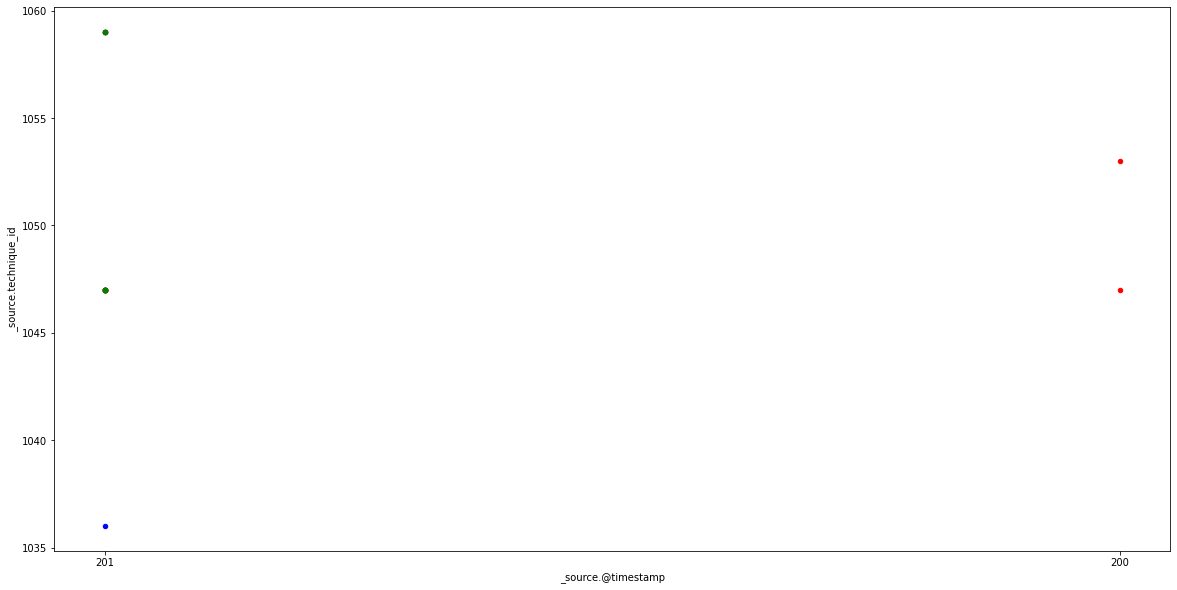

In [40]:
firstPlot = df5.plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id',color='blue',figsize=(20,10))
secplot = df_today_c.plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id', ax=firstPlot,color='red')
df_int.plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id', ax=secplot,color='green')
plt.show()

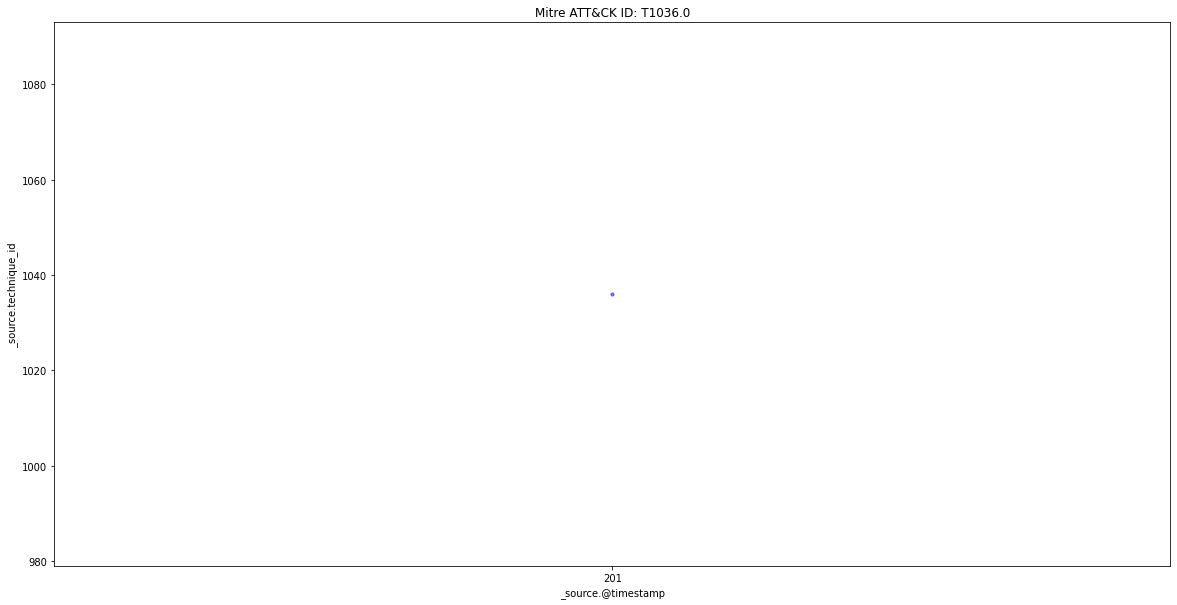

In [41]:
for (columnName, columnData) in df5.drop_duplicates(['_source.technique_id'])[['_source.technique_id']].iteritems():
    for i in columnData:
#         print(i)
#         plt.plot(df5[df5['_source.technique_id'] == i])
        firstPlot = df5[df5['_source.technique_id'] == i].plot(kind='scatter', x='_source.@timestamp', y='_source.technique_id', \
                                                              color='blue', figsize=(20,10), s=10, alpha=0.5, title="Mitre ATT&CK ID: T"+str(i))
        secplot = df_today_c[df_today_c['_source.technique_id'] == i].plot(kind='scatter', x='_source.@timestamp', y='_source.technique_id', 
                                                                                                      ax=firstPlot,color='red')
        df_int[df_int['_source.technique_id'] == i].plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id', 
                                                                                              ax=secplot,color='green')
        break
plt.show()

In [42]:
df_today_c_count = df_today_c.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')
df_today_c_count

_source.@timestamp  _source.technique_id
200                 1047.000                1
                    1053.000                1
201                 1047.000                5
                    1059.007                2
dtype: int64

In [43]:
pd.pivot_table(df5, index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)

_source.technique_id,1036.000,1047.000,1059.007
_source.@timestamp,,,
201,1,1,1


findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


Index(['201'], dtype='object', name='_source.@timestamp') _source.@timestamp
201    1
Name: 1036.0, dtype: int64


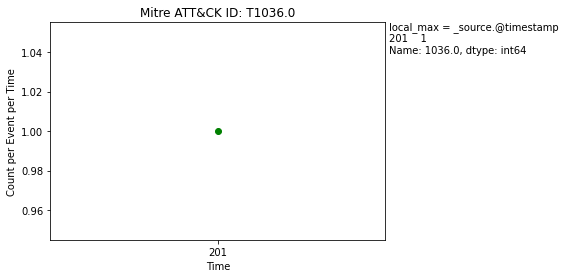

Index(['201'], dtype='object', name='_source.@timestamp') _source.@timestamp
201    1
Name: 1047.0, dtype: int64


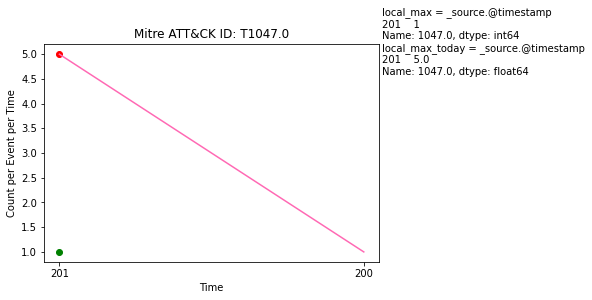

Index(['201'], dtype='object', name='_source.@timestamp') _source.@timestamp
201    1
Name: 1059.007, dtype: int64


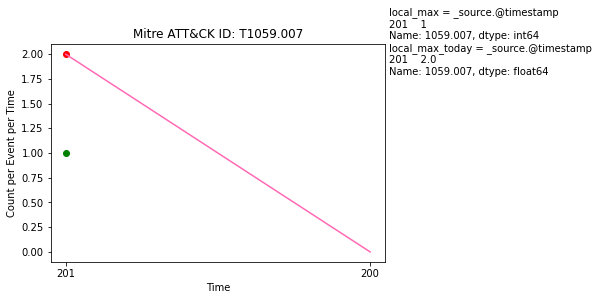

In [44]:
# for (columnName, columnData) in df_today_c_count.iteritems():
#   print(columnName)
#   aa = columnName[0]
#   bb = columnName[1]
#   print(aa)
#   print(bb)
#   print(columnData)

# df5_count = df5.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')
# df_today_c_count = df_today_c.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')
# df_int_count = df_int.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')

df5_count = pd.pivot_table(df5, index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)
df_today_c_count = pd.pivot_table(df_today_c, values='_source.technique_id', index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)
df_int_count = pd.pivot_table(df_int, values='_source.technique_id', index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)

idx = df5_count.index
for (columnName, columnData) in df5_count.iteritems():
  # print(idx.name, columnData.values)
  # for i in columnData:
  # print(columnName, i)
  # plt.plot(df5[df5['_source.technique_id'] == i])
  plt.plot(df5_count.index, list(df5_count[columnName]), color = "blue")
  ilocs_max = argrelextrema(df5_count[columnName].values, np.greater_equal, order=1000)[0]
  print(df5_count[columnName].iloc[ilocs_max].index, df5_count[columnName].iloc[ilocs_max])
  plt.scatter(df5_count[columnName].iloc[ilocs_max].index, df5_count[columnName].iloc[ilocs_max], color = "green")
  # plt.text(10, 50, r'local_max = %s' %(df5_count[columnName].iloc[ilocs_max]))

  # df5_count[columnName].iloc[ilocs_max].plot(x=df5_count.iloc[ilocs_max].name, style='.', lw=10, color='red', marker="v")
  try:
    plt.plot(df_today_c_count.index, list(df_today_c_count[columnName]), color = "hotpink")
    ilocs_max_today = argrelextrema(df_today_c_count[columnName].values, np.greater_equal, order=1000)[0]
    plt.scatter(df_today_c_count[columnName].iloc[ilocs_max_today].index, df_today_c_count[columnName].iloc[ilocs_max_today], color = "red")
    plt.text(1.01, 0.85, 'local_max = %s\nlocal_max_today = %s' %(df5_count[columnName].iloc[ilocs_max], df_today_c_count[columnName].iloc[ilocs_max_today]), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
  except Exception as e:
    # print(e)
    plt.text(1.01, 0.85, 'local_max = %s' %(df5_count[columnName].iloc[ilocs_max]), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
  # ilocs_min = argrelextrema(list(df5_count[columnName]), np.less_equal, order=3)[0]
  # ilocs_max = argrelextrema(list(df5_count[columnName]), np.greater_equal, order=3)[0]
  # print('ilocs_min', ilocs_min, 'ilocs_max', ilocs_max)
  # plt.bar(df_int_count.index, list(df_int_count[columnName]))
  plt.title("Mitre ATT&CK ID: T"+str(columnName))
  plt.xlabel('Time')
  plt.ylabel('Count per Event per Time')

  # firstPlot = df5_count[columnName].plot(kind='scatter', x=list([int(i) for i in df5_count.index]), y=columnData.values,
  #                                                       color='blue', figsize=(20,10), s=10, alpha=0.5, title="Mitre ATT&CK ID: T"+str(columnName))
  # secplot = df_today_c[df_today_c['_source.technique_id'] == i].plot(kind='scatter', x='_source.@timestamp', y='_source.technique_id', 
  #                                                                                               ax=firstPlot,color='red')
  # df_int[df_int['_source.technique_id'] == i].plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id', 
  #                                                                                       ax=secplot,color='green')
  # break
  plt.show()

In [45]:
print(df5_count)

_source.technique_id  1036.000  1047.000  1059.007
_source.@timestamp                                
201                          1         1         1


In [46]:
ilocs_min = argrelextrema(df5_count[1036.0].values, np.less_equal, order=60)[0][0]
ilocs_max = argrelextrema(df5_count[1036.0].values, np.greater_equal, order=60)[0][0]
print(ilocs_min, ilocs_max)
# df5_count[1547.01].iloc[ilocs_max].plot(style='.', lw=10, color='red', marker="v")
# df5_count[1547.01].iloc[ilocs_min].plot(style='.', lw=10, color='green', marker="^")

0 0


In [47]:
df5_today = df_today[['_source.@timestamp','_source.technique_id']]
df5_today = df5_today.sort_values(by='_source.@timestamp')
df5_today = df5_today.dropna()
df5_today = df5_today[df5_today['_source.technique_id'] != "Port Monitors"]
df5_today = df5_today[df5_today['_source.technique_id'] != "T"]

df5_today["_source.technique_id"] = df5_today['_source.technique_id'].str[1:].astype(np.double).replace(210,1210)
# df5_today["_source.@timestamp"] = pd.to_datetime(df5_today['_source.@timestamp'].astype(str)).values.astype(np.int64) // 10 ** 6
df5_today["_source.@timestamp"] = df5_today['_source.@timestamp'].astype(str).str[11:15].str.replace(':', '', regex=True)
df5_today.drop_duplicates(inplace = True)
df5_today

,_source.@timestamp,_source.technique_id
9887,200,1047.000
9543,200,1053.000
8169,201,1047.000
1145,201,1059.007


In [48]:
# float(df5_count.iloc[17].name)

In [49]:
random_state = np.random.RandomState(42)
model=IsolationForest(n_estimators=30,max_samples='auto',contamination=float(0.2),random_state=random_state)

model.fit(df5[['_source.technique_id']])

print(model.get_params())

df5_today_pred = df5

df5_today_pred['scores'] = model.decision_function(df5_today[['_source.technique_id']])

df5_today_pred['anomaly_score'] = model.predict(df5_today[['_source.technique_id']])

print(df5_today_pred[df5_today_pred['anomaly_score']==-1].to_string())
df5_today[df5_today['anomaly_score']==-1]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


{'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 30, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F1A63532AF0, 'verbose': 0, 'warm_start': False}


ValueError: ignored

In [ ]:
# accuracy = 100*list(df5_today['anomaly_score']).count(-1)/(anomaly_count)
# print("Accuracy of the model:", accuracy)

In [ ]:
random_state = np.random.RandomState(42)
model2=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=random_state)

model2.fit(df5_today[['_source.technique_id']])

print(model2.get_params())

df5['scores'] = model2.decision_function(df5[['_source.technique_id']])

df5['anomaly_score'] = model2.predict(df5[['_source.technique_id']])

df5[df5['anomaly_score']==-1]

In [ ]:
# for (columnName, columnData) in df_today_c_count.iteritems():
#   print(columnName)
#   aa = columnName[0]
#   bb = columnName[1]
#   print(aa)
#   print(bb)
#   print(columnData)

# df5_count = df5.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')
# df_today_c_count = df_today_c.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')
# df_int_count = df_int.pivot_table(index = ['_source.@timestamp', '_source.technique_id'], aggfunc ='size')

df5_count = pd.pivot_table(df5, index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)
df_today_c_count = pd.pivot_table(df_today_c, values='_source.technique_id', index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)
df_int_count = pd.pivot_table(df_int, values='_source.technique_id', index=['_source.@timestamp'],columns=['_source.technique_id'], aggfunc='size').fillna(0)

idx = df5_count.index
for (columnName, columnData) in df5_count.iteritems():
  plt.figure(figsize=(20,10))
  # print(idx.name, columnData.values)
  # for i in columnData:
  # print(columnName, i)
  # plt.plot(df5[df5['_source.technique_id'] == i])
  plt.plot(df5_count.index, list(df5_count[columnName]), color = "blue")
  ilocs_max = argrelextrema(df5_count[columnName].values, np.greater, order=3)[0]
  # print(df5_count[columnName].iloc[ilocs_max].index, df5_count[columnName].iloc[ilocs_max])
  plt.scatter(df5_count[columnName].iloc[ilocs_max].index, df5_count[columnName].iloc[ilocs_max], color = "green")
  # plt.text(10, 50, r'local_max = %s' %(df5_count[columnName].iloc[ilocs_max]))

  # df5_count[columnName].iloc[ilocs_max].plot(x=df5_count.iloc[ilocs_max].name, style='.', lw=10, color='red', marker="v")
  try:
    plt.plot(df_today_c_count.index, list(df_today_c_count[columnName]), color = "hotpink")
    ilocs_max_today = argrelextrema(df_today_c_count[columnName].values, np.greater, order=3)[0]
    plt.scatter(df_today_c_count[columnName].iloc[ilocs_max_today].index, df_today_c_count[columnName].iloc[ilocs_max_today], color = "red")
    df5_today_plot = df5_today_pred.query("`anomaly_score` == -1 and `_source.technique_id` == %s" %columnName).sort_values(by='_source.@timestamp')
    # df5_today_plot['_source.@timestamp'].to_list()
    
    for lines in df5_today_plot['_source.@timestamp'].to_list():
      plt.axvline(x=lines, color='black', linestyle='--')

    plt.text(1.01, 0.01, 'Anomaly Time = %s' %(df5_today_plot['_source.@timestamp'].to_list()), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes)
    plt.text(1.01, 0.10, 'local_max = %s\nlocal_max_today = %s' %(df5_count[columnName].iloc[ilocs_max], df_today_c_count[columnName].iloc[ilocs_max_today]), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
  except Exception as e:
    # print(e)
    plt.text(1.01, 0.01, 'Anomaly Time = %s' %(df5_today_plot['_source.@timestamp'].to_list()), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes)
    plt.text(1.01, 0.10, 'local_max = %s' %(df5_count[columnName].iloc[ilocs_max]), 
         fontsize=10, fontfamily='Georgia', color='k',
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
  # ilocs_min = argrelextrema(list(df5_count[columnName]), np.less_equal, order=3)[0]
  # ilocs_max = argrelextrema(list(df5_count[columnName]), np.greater_equal, order=3)[0]
  # print('ilocs_min', ilocs_min, 'ilocs_max', ilocs_max)
  # plt.bar(df_int_count.index, list(df_int_count[columnName]))
  plt.title("Mitre ATT&CK ID: T"+str(columnName))
  plt.xlabel('Time')
  plt.ylabel('Count per Event per Time')
  

  # firstPlot = df5_count[columnName].plot(kind='scatter', x=list([int(i) for i in df5_count.index]), y=columnData.values,
  #                                                       color='blue', figsize=(20,10), s=10, alpha=0.5, title="Mitre ATT&CK ID: T"+str(columnName))
  # secplot = df_today_c[df_today_c['_source.technique_id'] == i].plot(kind='scatter', x='_source.@timestamp', y='_source.technique_id', 
  #                                                                                               ax=firstPlot,color='red')
  # df_int[df_int['_source.technique_id'] == i].plot(kind='scatter',x='_source.@timestamp',y='_source.technique_id', 
  #                                                                                       ax=secplot,color='green')
  # break
  plt.show()

In [ ]:
aa=1021.0
df5_today_plot = df5_today.query("`anomaly_score` == -1 and `_source.technique_id` == %s" %aa).sort_values(by='_source.@timestamp')
df5_today_plot['_source.@timestamp'].to_list()